#### 08.04.25, &copy; Barbir Vladyslav KI-21-1

# Лабораторна робота №6. Метод головних компонент. Метричні методи класифікації

__Мета__: закріпити на практиці концепцію байєсівського вивода засобами мови Python

## Що ви будете вміти?
* Реалізовувати метод голових компонент засобами мови Python
* Виконувати стиснення зображень з втратами на основі PCA
* Реалізувати kNN-класифікатор з різними віконними функціями засобами мови Python

## Завдання для самостійної роботи 

1. Імпортувати декілька власних довільних зображень, включаючи і власне фото.

In [7]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

image_paths = ["lab_6/img/1.jpg", "lab_6/img/2.jpg", "lab_6/img/3.jpg", "lab_6/img/4.jpg"]

def load_and_prepare_images(image_paths, target_size=(100, 100)):
    images = []
    for path in image_paths:
        img = Image.open(path).convert('L') 
        img = img.resize(target_size)  
        img_array = np.array(img).flatten() 
        images.append(img_array)
    return np.array(images), target_size

images, image_shape = load_and_prepare_images(image_paths)

2. Стиснути його в 20, 30, 50 разів, як показано в прикладах. Вивести і прокоментувати результати.

Using n_components=4 (max allowed: 4)


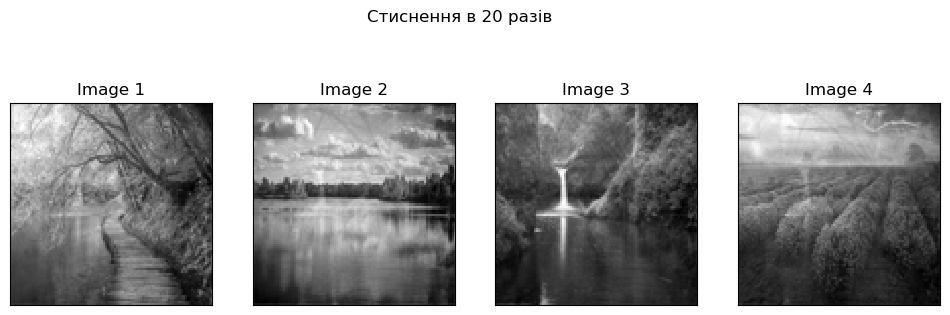

Using n_components=4 (max allowed: 4)


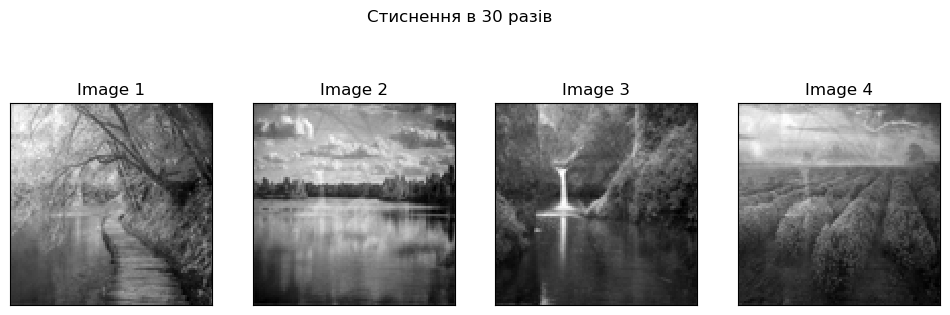

Using n_components=4 (max allowed: 4)


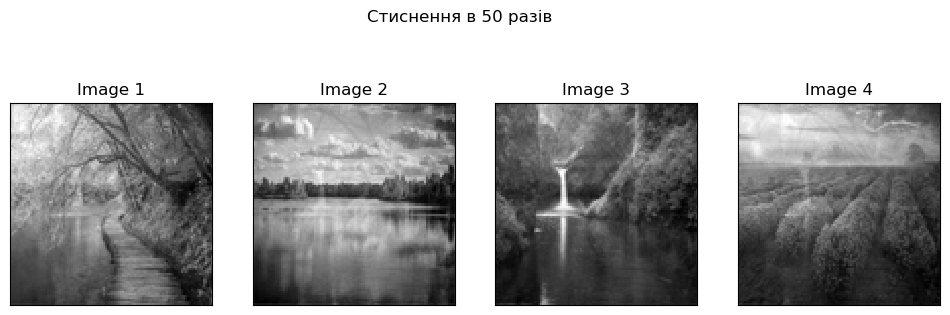

In [11]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Список шляхів до зображень
image_paths = [
    "lab_6/img/1.jpg",
    "lab_6/img/2.jpg",
    "lab_6/img/3.jpg",
    "lab_6/img/4.jpg"
]

def load_and_prepare_images(image_paths, target_size=(100, 100)):
    images = []
    for path in image_paths:
        img = Image.open(path).convert('L')
        img = img.resize(target_size)
        img_array = np.array(img).flatten()
        images.append(img_array)
    return np.array(images), target_size

images, image_shape = load_and_prepare_images(image_paths)

mean_image = np.mean(images, axis=0)

def compress_and_show(compress_ratio, images, image_shape, mean_image):
    base_size = image_shape[0] * image_shape[1]
    n_components = int(base_size * compress_ratio)
    
    n_samples = images.shape[0]
    n_features = images.shape[1]
    max_components = min(n_samples, n_features)
    n_components = min(n_components, max_components)
    
    print(f"Using n_components={n_components} (max allowed: {max_components})")

    model_pca = PCA(n_components=n_components)
    model_pca.fit(images)

    images_compressed = model_pca.transform(images)
    
    images_restored = model_pca.inverse_transform(images_compressed) + mean_image

    plt.figure(figsize=(12, 4))
    rows, cols = 1, len(images)
    for i in range(len(images)):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(images_restored[i, :].reshape(image_shape), interpolation='none', cmap='gray')
        plt.title(f"Image {i+1}")
        plt.xticks(())
        plt.yticks(())
    
    compression_factor = int(1 / compress_ratio)
    plt.suptitle(f"Стиснення в {compression_factor} разів")
    plt.show()
    
    return images_compressed, images_restored

compress_ratios = [0.05, 0.033, 0.02] 
for ratio in compress_ratios:
    compressed, restored = compress_and_show(ratio, images, image_shape, mean_image)

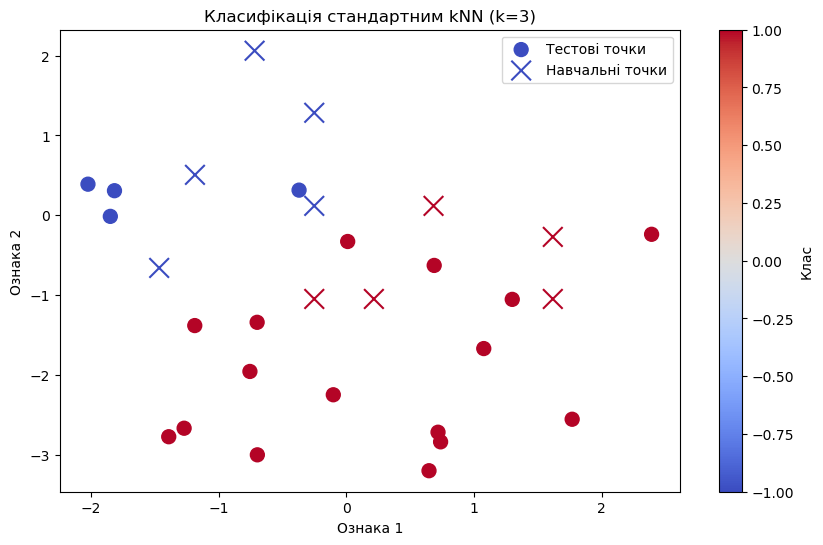

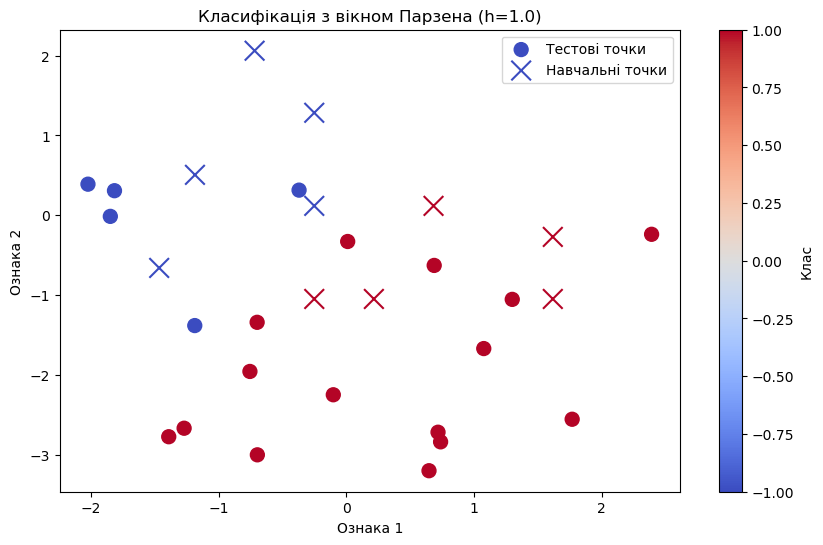

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

x_train_1 = np.array([
    [10, 50],
    [20, 30],
    [25, 30],
    [20, 60],
    [15, 70],
    [40, 40],
    [30, 45],
    [20, 45],
    [40, 30],
    [7, 35]
])
y_train_1 = np.array([-1, 1, 1, -1, -1, 1, 1, -1, 1, -1])

np.random.seed(42)
x_test = np.random.uniform(low=0, high=50, size=(20, 2)) 

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train_1)
x_test = scaler.transform(x_test)

def euclidean_distance(a, b):
    return np.sqrt(np.sum((a - b) ** 2))

# KNN
def knn_predict(x_train, y_train, x_test, k):
    y_pred = []
    for test_point in x_test:
        distances = [euclidean_distance(test_point, train_point) for train_point in x_train]
        k_indices = np.argsort(distances)[:k]
        k_nearest_labels = y_train[k_indices]
        unique_labels, counts = np.unique(k_nearest_labels, return_counts=True)
        predicted_label = unique_labels[np.argmax(counts)]
        y_pred.append(predicted_label)
    return np.array(y_pred)

k = 3
y_pred_knn = knn_predict(x_train, y_train_1, x_test, k)

plt.figure(figsize=(10, 6))
plt.scatter(x_test[:, 0], x_test[:, 1], c=y_pred_knn, cmap='coolwarm', s=100, label='Тестові точки')
plt.scatter(x_train[:, 0], x_train[:, 1], c=y_train_1, cmap='coolwarm', marker='x', s=200, label='Навчальні точки')
plt.title(f'Класифікація стандартним kNN (k={k})')
plt.xlabel('Ознака 1')
plt.ylabel('Ознака 2')
plt.legend()
plt.colorbar(label='Клас')
plt.show()

def gaussian_kernel(distance, h):
    return np.exp(-distance**2 / (2 * h**2))

def parzen_window_predict(x_train, y_train, x_test, h):
    y_pred = []
    for test_point in x_test:
        distances = [euclidean_distance(test_point, train_point) for train_point in x_train]
        weights = [gaussian_kernel(d, h) for d in distances]
        class_weights = {}
        for label in np.unique(y_train):
            class_weights[label] = sum(w for w, l in zip(weights, y_train) if l == label)
        predicted_label = max(class_weights, key=class_weights.get)
        y_pred.append(predicted_label)
    return np.array(y_pred)

h = 1.0 
y_pred_parzen = parzen_window_predict(x_train, y_train_1, x_test, h)

plt.figure(figsize=(10, 6))
plt.scatter(x_test[:, 0], x_test[:, 1], c=y_pred_parzen, cmap='coolwarm', s=100, label='Тестові точки')
plt.scatter(x_train[:, 0], x_train[:, 1], c=y_train_1, cmap='coolwarm', marker='x', s=200, label='Навчальні точки')
plt.title(f'Класифікація з вікном Парзена (h={h})')
plt.xlabel('Ознака 1')
plt.ylabel('Ознака 2')
plt.legend()
plt.colorbar(label='Клас')
plt.show()


**Візуалізація**

- Стандартний kNN: чіткі межі, але нестабільні через малий набір (10 точок).

- Вікно Парзена: плавні межі, корисні для складних класів, але чутливі до h і малого обсягу даних.

**Практичні висновки**

- Стандартний kNN: ефективний для чітко розділених класів, k=3 — розумний вибір, але малий обсяг даних → перенавчання.

- Вікно Парзена: гнучкіший, але потребує підбору h (1.0 може бути неоптимальним, спробувати 0.5, 2.0).

- Малий розмір даних: 10 точок — замало для kNN, особливо для Парзена; потрібно більше даних.

4. Дати відповіді на контрольні запитання.

5. Відправити результати роботи у файлі lab_6_StudentLastName.ipynb до віддаленого репозиторію на GіtHub

## Контрольні питання

1. У чому полягає ідея методу головних компонент (PCA)?

**Ідея PCA (Метод Головних Компонент):**

*   **Мета:** Зменшити розмірність даних, втративши мінімум інформації.
*   **Як:** Знаходить нові, некорельовані осі (головні компоненти) в даних, які послідовно пояснюють максимальну кількість дисперсії (варіативності).
*   **Результат:** Проектує вихідні дані на ці нові осі, створюючи подання даних у просторі меншої розмірності, де нові ознаки (компоненти) є лінійними комбінаціями старих і впорядковані за важливістю (кількістю поясненої дисперсії).

2. Яким чином метод головних компонент використовується для зменшення розмірності даних?

**Зменшення розмірності за допомогою PCA:**

1.  **Знаходження Головних Компонент:** PCA знаходить нові осі (головні компоненти), які є лінійними комбінаціями вихідних ознак і впорядковані за кількістю дисперсії (варіативності) даних, яку вони пояснюють. Перша компонента пояснює найбільшу дисперсію, друга – наступну найбільшу (і є ортогональною до першої), і так далі.

2.  **Вибір Компонент:** Вирішується, скільки компонент залишити (`k`). Це робиться на основі бажаного відсотка збереженої дисперсії (наприклад, 95% або 99%). Вибираються перші `k` компонент, які разом досягають цього порогу. Компоненти з найменшою дисперсією (які часто представляють шум або менш значущі патерни) відкидаються.

3.  **Трансформація Даних:** Вихідні дані проектуються на новий простір, утворений вибраними `k` головними компонентами. Кожна точка даних тепер представляється `k` новими координатами замість початкових `d` (`k < d`).

**Результат:** Новий набір даних має значно меншу кількість ознак (`k` замість `d`), але зберігає більшу частину інформації (дисперсії) вихідних даних.

3. Як пов’язані PCA та SVD? Як його можна використовувати для аналізу даних?

**Зв'язок PCA та SVD:**

*   **Основа:** PCA та SVD математично тісно пов'язані.
*   **Суть:** PCA шукає головні компоненти (власні вектори коваріаційної матриці даних). SVD розкладає матрицю даних `X` на `UΣVᵀ`.
*   **Ключовий зв'язок:** **Праві сингулярні вектори (`V` з SVD) і є головними компонентами PCA.** Сингулярні значення (`Σ`) відповідають дисперсії цих компонент.
*   **Перевага:** Обчислення PCA через SVD часто є чисельно стабільнішим.

**Використання SVD/PCA:**

*   **Основне:** SVD знаходить компоненти для **зменшення розмірності (PCA)**, зберігаючи максимум дисперсії.
*   **Інше:** Шумозаглушення, виявлення прихованих (латентних) факторів (LSA, рекомендаційні системи), стиснення даних (напр., зображень), аналіз колінеарності.

4. Які метрики якості використовуються в багатокласовій класифікації?

*   **Матриця помилок (Confusion Matrix):** Показує TP/FP/TN/FN для кожного класу.
*   **Точність (Accuracy):** Загальна частка правильних прогнозів (може бути оманливою).
*   **Точність (Precision), Повнота (Recall), F1-міра:**
    *   **Макро-усереднення:** Середнє по класах (рівна вага класів).
    *   **Мікро-усереднення:** Загальне по всіх екземплярах (рівна вага екземплярів, дорівнює Accuracy).
    *   **Зважене усереднення:** Середнє по класах, зважене на їх розмір.
*   **Логарифмічна втрата (Log Loss):** Оцінює якість прогнозованих ймовірностей.
*   **Каппа Коена (Cohen's Kappa):** Точність, скоригована на випадковість.

5. Чим відрізняються стратегії one-vs-all та all-vs-all у багатокласовій класифікації?

*   **One-vs-All (OvA) / One-vs-Rest (OvR):**
    *   Будує **N** бінарних класифікаторів (де N - кількість класів).
    *   Кожен класифікатор вчиться відрізняти **один** клас від **усіх інших** разом узятих.
    *   Прогноз: Обирається клас, чий класифікатор дав найвищу оцінку впевненості.

*   **All-vs-All (AvA) / One-vs-One (OvO):**
    *   Будує **N * (N - 1) / 2** бінарних класифікаторів.
    *   Кожен класифікатор вчиться відрізняти **одну пару** класів.
    *   Прогноз: Кожен класифікатор "голосує" за один клас зі своєї пари. Перемагає клас, що набрав найбільше голосів.

6. Що таке гіпотеза компактності в метричних методах класифікації?

Припущення, що об'єкти, які належать до **одного класу**, розташовані **близько** один до одного (утворюють компактні групи) у просторі ознак, тоді як об'єкти **різних класів** знаходяться **далеко** один від одного.

**Суть:** Близькість у просторі ознак означає належність до одного класу. На цьому базуються методи типу k-NN (k-найближчих сусідів).

7. Як працює метод k-найближчих сусідів (kNN)? Які його переваги та недоліки?

*   **Як працює:**
    1.  Для нового об'єкта знаходить **k** найближчих до нього об'єктів (сусідів) з навчальної вибірки за допомогою метрики відстані (напр., Евклідової).
    2.  Присвоює новому об'єкту клас, який є **найпоширенішим** серед його k сусідів (принцип більшості).
    *   *Важливо:* Метод "лінивий" - явного навчання немає, всі обчислення відбуваються на етапі прогнозування.

*   **Переваги:**
    *   Простий в реалізації та інтерпретації.
    *   Не потребує тренування моделі (ліниве навчання).
    *   Ефективний для даних зі складними, нелінійними межами між класами.
    *   Легко адаптується до нових даних.

*   **Недоліки:**
    *   **Обчислювально дорогий** на етапі прогнозування (треба обчислити відстані до всіх навчальних точок).
    *   Чутливий до **вибору k** та **метрики відстані**.
    *   Страждає від **"прокляття розмірності"** (погано працює з даними високої розмірності та нерелевантними ознаками).
    *   Потребує **масштабування ознак**.
    *   Вимагає зберігання **всієї навчальної вибірки**.

8. У чому полягає суть методу парзенівського вікна? Які його недоліки та переваги?

*   **Суть:**
    *   Непараметричний метод для оцінки функції щільності ймовірності (PDF) даних.
    *   Розміщує "вікно" (ядерну функцію, наприклад, Гауссову) з фіксованою шириною (`h` - параметр згладжування) навколо *кожної* точки навчальної вибірки.
    *   Оцінка PDF у будь-якій точці простору - це усереднений внесок вікон від усіх навчальних точок.
    *   **Для класифікації:** Оцінюється PDF для кожного класу окремо; новий об'єкт відноситься до класу з найвищою оцінкою PDF в його точці.

*   **Переваги:**
    *   Не робить припущень про форму розподілу даних (непараметричний).
    *   Може моделювати складні, мультимодальні розподіли.
    *   При достатній кількості даних збігається до справжньої щільності.
    *   Дає гладку оцінку щільності.

*   **Недоліки:**
    *   **Вибір ширини вікна (`h`) є критичним** і складним (впливає на згладжування).
    *   **Обчислювально дорогий:** Потребує обчислення внеску від усіх навчальних точок для кожної нової точки.
    *   Вимагає зберігання **всієї навчальної вибірки**.
    *   Страждає від **"прокляття розмірності"** (погано працює в просторах високої розмірності).

9. У чому полягає суть методу потенційних функцій у метричних методах класифікації? Які його недоліки та переваги?

*   **Суть:**
    *   Ітеративний метод навчання класифікатора.
    *   Кожен об'єкт навчальної вибірки створює "потенційне поле" навколо себе (за допомогою потенційної функції, що спадає з відстанню).
    *   Будується сумарна розділяюча функція, яка є сумою (з урахуванням знаку класу) потенціалів від навчальних об'єктів.
    *   **Навчання:** Проходимо по вибірці; якщо об'єкт класифікується неправильно поточною сумарною функцією, його потенціал *додається* (якщо позитивний клас) або *віднімається* (якщо негативний) до сумарної функції, коригуючи її.
    *   **Класифікація:** Знак сумарної функції в точці нового об'єкта визначає його клас.

*   **Переваги:**
    *   Гарантована збіжність для лінійно роздільних вибірок (подібно до перцептрону).
    *   Може створювати нелінійні розділяючі поверхні (залежно від вибору потенційної функції).
    *   Приводить до побудови явної розділяючої функції.
    *   Можливість онлайн-навчання (поступове додавання даних).

*   **Недоліки:**
    *   **Вибір потенційної функції та її параметрів** є критичним і не завжди очевидним.
    *   Швидкість збіжності може бути низькою, особливо для великих або "складних" вибірок.
    *   Чутливий до викидів та шуму в даних, які можуть сильно впливати на підсумкову функцію.
    *   Обчислювальна складність навчання може бути високою.